# A/B 테스트 - 이커머스

In [ ]:
!pip install statsmodels

In [ ]:
# 필요한 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.stats.api as sms
from math import ceil
from scipy.stats import beta
from scipy.stats import norm
from scipy.stats import chisquare
from math import sqrt




## EDA

In [ ]:
df = pd.read_csv("ab_data.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.nunique()

,0
user_id,290584
timestamp,294478
group,2
landing_page,2
converted,2


group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64


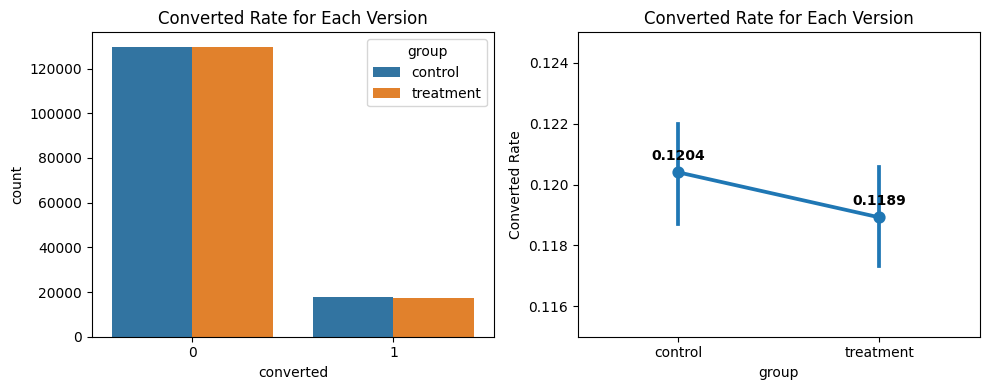

In [ ]:
# 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Countplot
sns.countplot(x='converted', data=df, hue='group', ax=axes[0])
axes[0].set_title('Converted Rate for Each Version')

# Pointplot
sns.pointplot(x="group", y="converted", data=df, ax=axes[1])
axes[1].set_ylim([0.115, 0.125])
axes[1].set(title="Converted Rate for Each Version", ylabel="Converted Rate")

# 그룹별 평균 전환율 계산
conversion_rate = df.groupby('group')['converted'].mean()
print(conversion_rate)

# 그래프에 mean 값 표시
for i, (group, rate) in enumerate(conversion_rate.items()):
    axes[1].text(i, rate + 0.0003, f"{rate:.4f}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

In [ ]:
conversion_rates = df.groupby('group')['converted']

# 표준편차 계산 함수 정의
# ddof = 0 : 모집단 표준편차 계산
std_p = lambda x : np.std(x, ddof = 0)

# 표준오차 계산 함수 정의
# 전환율의 추정치 신뢰도
se_p = lambda x : stats.sem(x, ddof = 0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

/tmp/ipython-input-2660160524.py:13: FutureWarning: The provided callable <function mean at 0x7f218a7bb880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001


In [ ]:
# 중복 user_id를 제거 전

pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [ ]:
# 각 홈페이지 마다 한 번 이상 방문한 사람들을 빼고 실험

session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users)

3894


In [ ]:
# session_counts 가 1을 초과하는 경우 해당 user_id를 가지고 있는 행 drop
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])

286690


In [ ]:
# 중복 user_id 제거 후
pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [ ]:
## 앞의 행을 대신 사용하는 방법도 있음
# #drop duplicate:
# df.drop_duplicates(subset ='user_id',keep ='first',inplace = True)

In [ ]:
## 샘플 사이즈 결정하기

# Control 그룹의 전환율
p1 = df[df['group'] == 'control']['converted'].mean()
print(f"Baseline Conversion Rate (p₁): {p1:.2%}")


Baseline Conversion Rate (p₁): 12.02%


In [ ]:
# 기존 전환율(p_A)과 기대 전환율(p_B)
p_A = 0.12  # 기존 12%
p_B = 0.14  # 기대 14%

# 유의수준(alpha)와 검정력(power)
alpha = 0.05   # 5%
power = 0.9    # 80%

# 효과 크기(effect size) 계산
effect_size = proportion_effectsize(p_A, p_B)

# 검정력 분석을 수행하여 필요한 샘플 크기 계산 (각 그룹당 필요한 n)
analysis = NormalIndPower()
n_per_group = analysis.solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=1.0
    )

print(f"각 그룹에 필요한 샘플 수: {n_per_group:.0f}")
print(f"총 샘플 수: {n_per_group*2:.0f}")

각 그룹에 필요한 샘플 수: 5934
총 샘플 수: 11868


In [ ]:
# control, treatment 각각 5934개의 데이터 확보

required_n = 5934

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state = 7)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state = 7)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

# 표준편차 계산 함수 정의
std_p = lambda x : np.std(x, ddof = 0)

# 표준오차 계산 함수 정의
se_p = lambda x : stats.sem(x, ddof = 0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

/tmp/ipython-input-3734311846.py:13: FutureWarning: The provided callable <function mean at 0x7f218a7bb880> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.127,0.333,0.004
treatment,0.121,0.326,0.004



## Time-Based Analysis

In [ ]:
# 데이터 불러오기
df = pd.read_csv("ab_data.csv")

# 여러번 방문한 유저 탐색 및 제거
session_counts = df['user_id'].value_counts()         # 각 유저 방문 횟수 계산
multi_users = (session_counts > 1).sum()             # 1회 초과 방문 유저 수
print("multi users :", multi_users)

user_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(user_to_drop)]           # 다중 방문 유저 제거
print("The new df users :", df.shape[0])

multi users : 3894
The new df users : 286690


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
hourly_conversion_rates = df.groupby('hour')['converted'].mean()

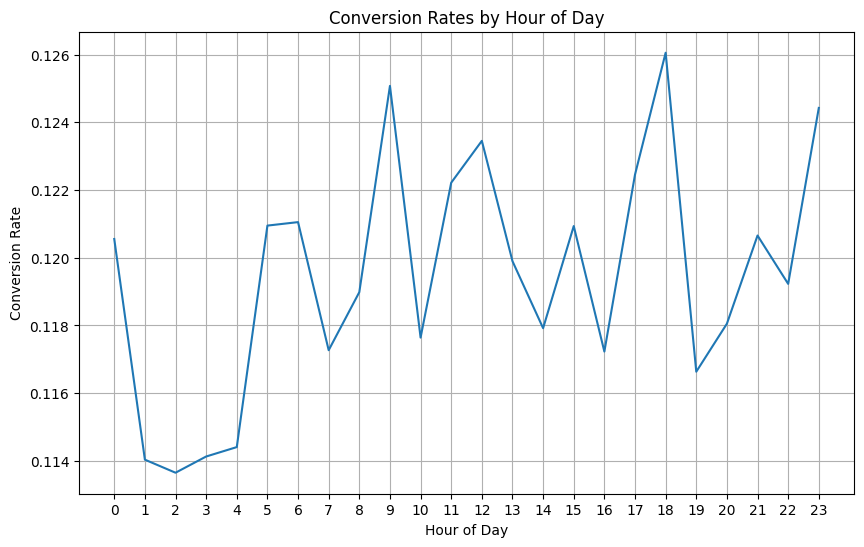

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion_rates.index, hourly_conversion_rates.values)
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Hour of Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

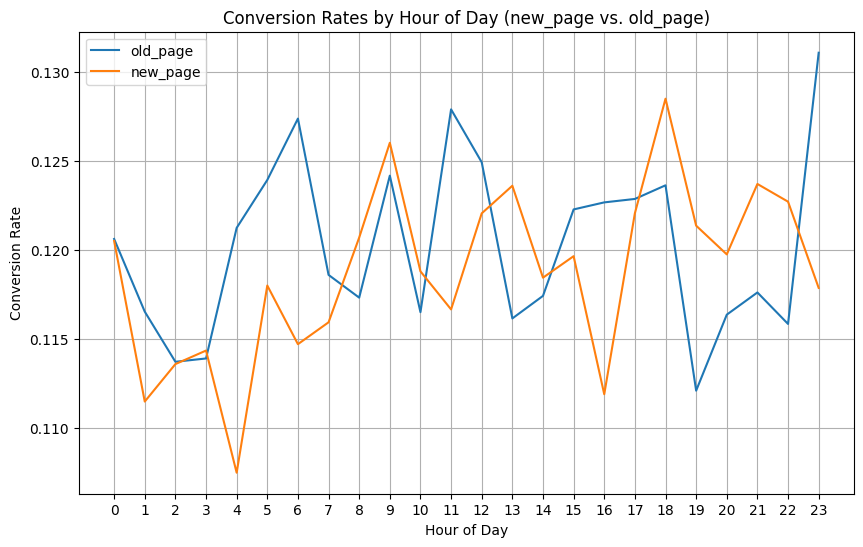

In [ ]:
# hour와 landing_page를 기준으로 그룹화하여
# 각 시간대와 랜딩 페이지 조합별 평균 전환율 계산함
hourly_conversion_by_page = df.groupby(['hour', 'landing_page'])['converted'].mean().unstack()

plt.figure(figsize=(10, 6))
plt.plot(hourly_conversion_by_page.index, hourly_conversion_by_page['old_page'], label='old_page')
plt.plot(hourly_conversion_by_page.index, hourly_conversion_by_page['new_page'], label='new_page')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Hour of Day (new_page vs. old_page)')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

## z-test A/B 테스트

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs = nobs, alpha = 0.05)
# 비율에 대한 신뢰구간 계산

print(f"Z-statistic: {z_stat:.2f}")
print(f"P-value: {pval:.3f}")
print(f"CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]")
print(f"CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]")


Z-statistic: 1.06
P-value: 0.290
CI 95% for control group: [0.119, 0.136]
CI 95% for treatment group: [0.112, 0.129]


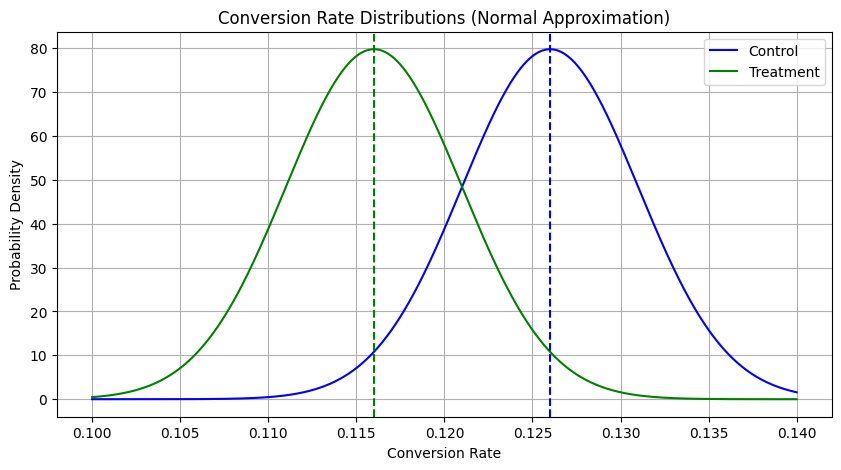

In [ ]:
# 전환율 (conversion rate)
p_con = 0.126
p_treat = 0.116

# 표준오차 (standard error)
se_con = 0.005
se_treat = 0.005

# x 축 범위 설정 (평균 ± 4*SE 범위)
x = np.linspace(0.10, 0.14, 1000)

# 정규분포 곡선
y_con = norm.pdf(x, p_con, se_con)
y_treat = norm.pdf(x, p_treat, se_treat)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(x, y_con, label='Control', color='blue')
plt.plot(x, y_treat, label='Treatment', color='green')
plt.axvline(p_con, color='blue', linestyle='--')
plt.axvline(p_treat, color='green', linestyle='--')
plt.title('Conversion Rate Distributions (Normal Approximation)')
plt.xlabel('Conversion Rate')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


## 카이제곱 A/B 테스트

In [ ]:
# 데이터 불러오기
df = pd.read_csv("ab_data.csv")

session_counts = df['user_id'].value_counts(ascending = False)
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]

pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [ ]:
# Conversion Rate
df_counts = pd.DataFrame({"Control_COUNT": df[df.group=="control"].converted.value_counts(),
              "Treatment_COUNT": df[df.group=="treatment"].converted.value_counts(),
              "Control_RATIO": df[df.group=="control"].converted.value_counts()/ len(df[df.group=="control"]),
              "Trement_RATIO": df[df.group=="treatment"].converted.value_counts() / len(df[df.group=="treatment"])})
df_counts

,Control_COUNT,Treatment_COUNT,Control_RATIO,Trement_RATIO
converted,,,,
0,126073,126372,0.879827,0.881274
1,17220,17025,0.120173,0.118726


In [ ]:
table = df_counts.iloc[:,0:2].to_numpy()
table

array([[126073, 126372],
       [ 17220,  17025]])

In [ ]:
def AB_testing(dataframe, group, metric, detailed=False):
    # 그룹 분리
    group_c = dataframe[dataframe[group] == "control"][metric]
    group_t = dataframe[dataframe[group] == "treatment"][metric]

    # 교차표 생성
    table = pd.DataFrame({
        "control": group_c.value_counts(),
        "treatment": group_t.value_counts()
    }).to_numpy()

    # 샘플 크기
    size = dataframe.shape[0]

    # 검정 선택
    if size < 1000:
        test_name = "Fisher Exact Test"
        odd_ratio, p_value = stats.fisher_exact(table, alternative="two-sided")
        stat, dof, expected = np.nan, np.nan, None
    else:
        test_name = "Chi Square Test"
        stat, p_value, dof, expected = stats.chi2_contingency(table)

    # 결과 요약
    result = pd.DataFrame({
        "Test": [test_name],
        "P_value": [p_value],
        "AB Hypothesis": ["Reject H0" if p_value < 0.05 else "Fail to Reject H0"],
        "Comment": ["A/B groups are not similar!" if p_value < 0.05 else "A/B groups are similar!"]
    })

    # 세부 내용 출력 (옵션)
    if detailed and test_name == "Chi Square Test":
        prob = 0.95
        critical = stats.chi2.ppf(prob, dof)
        print(f"[Detailed Chi-Square Info]")
        print(f"Degrees of Freedom = {dof}")
        print(f"Expected Table:\n{expected}")
        print(f"Statistic={stat:.3f}, Critical={critical:.3f}, p={p_value:.4f}")
        print(f"Decision: {'Reject H0 (Dependent)' if stat >= critical else 'Fail to Reject H0 (Independent)'}")
        print("-"*50)

    return result

AB_testing(df, group="group", metric="converted", detailed=True)


[Detailed Chi-Square Info]
Degrees of Freedom = 1
Expected Table:
[[126176.71137814 126268.28862186]
 [ 17116.28862186  17128.71137814]]
Statistic=1.413, Critical=3.841, p=0.2345
Decision: Fail to Reject H0 (Independent)
--------------------------------------------------


,Test,P_value,AB Hypothesis,Comment
0,Chi Square Test,0.234547,Fail to Reject H0,A/B groups are similar!


## 베이지안 A/B 테스트

In [ ]:
# ---- 데이터 로드 & 중복 제거 ----
df = pd.read_csv("ab_data.csv")
df = df[~df.duplicated(subset=["user_id"], keep=False)]

# 그룹별 방문 수와 전환 수 계산
visit_A = df[df['group'] == 'control'].shape[0]
conv_A = df[(df['group'] == 'control') & (df['converted'] == 1)].shape[0]

visit_B = df[df['group'] == 'treatment'].shape[0]
conv_B = df[(df['group'] == 'treatment') & (df['converted'] == 1)].shape[0]

# ---- 베이지안 사후분포 ----
alpha_prior, beta_prior = 1, 1
postA = (alpha_prior + conv_A, beta_prior + visit_A - conv_A)
postB = (alpha_prior + conv_B, beta_prior + visit_B - conv_B)

# 사후 샘플링
N = 200_000
rng = np.random.default_rng(42)
sA = beta.rvs(*postA, size=N, random_state=rng)
sB = beta.rvs(*postB, size=N, random_state=rng)

# Treatment > Control 확률 계산
prob_B_better = (sB > sA).mean()

# 사후 평균 전환율
mean_A = sA.mean()
mean_B = sB.mean()

# Lift 계산 (비율)
lift = sB / sA
lift_mean = lift.mean()
lift_CrI = np.quantile(lift, [0.025, 0.975])

print(f"A: {conv_A}/{visit_A} ({mean_A:.3%}), B: {conv_B}/{visit_B} ({mean_B:.3%})")
print(f"P(Treatment > Control) = {prob_B_better:.3%}")
print(f"Lift 평균 = {lift_mean:.3f} (95% CrI = [{lift_CrI[0]:.3f}, {lift_CrI[1]:.3f}])")


A: 17220/143293 (12.018%), B: 17025/143397 (11.873%)
P(Treatment > Control) = 11.733%
Lift 평균 = 0.988 (95% CrI = [0.969, 1.008])


In [ ]:
# postA, postB가 (alpha_post, beta_post) 튜플인 상태라고 가정
aA, bA = postA
aB, bB = postB

posterior_A = beta(aA, bA)   # frozen distribution
posterior_B = beta(aB, bB)   # frozen distribution

# 파라미터 출력
print("posterior_A:", aA, bA)
print("posterior_B:", aB, bB)


posterior_A: 17221 126074
posterior_B: 17026 126373


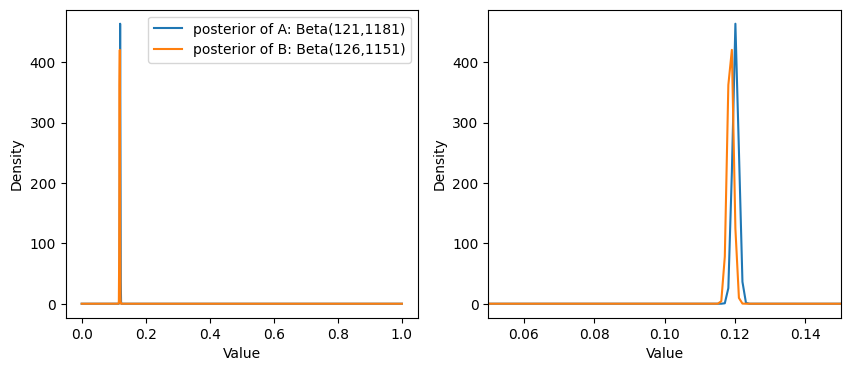

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
x = np.linspace(0,1,1000)
i=0
for ax in axes:
    ax.plot(x, posterior_A.pdf(x), label = "posterior of A: Beta(121,1181)")
    ax.plot(x, posterior_B.pdf(x), label = "posterior of B: Beta(126,1151)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    if i==1:
        ax.set_xlim(0.05, 0.15)
    i+=1
axes[0].legend()

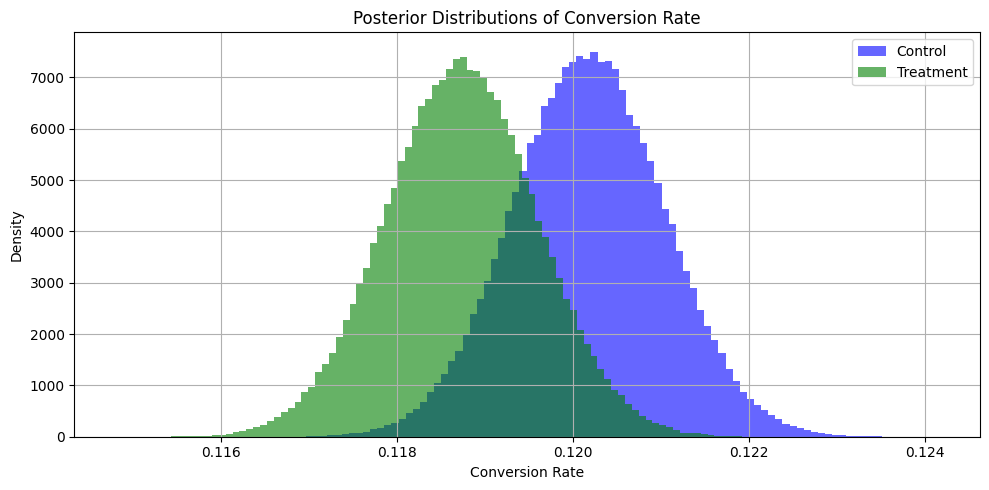

In [ ]:
samples_A = sA
samples_B = sB

# Beta 분포에서 샘플링한 전환율 값들의 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(samples_A, bins=100, alpha=0.6, label='Control', color='blue')
plt.hist(samples_B, bins=100, alpha=0.6, label='Treatment', color='green')
plt.title("Posterior Distributions of Conversion Rate")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

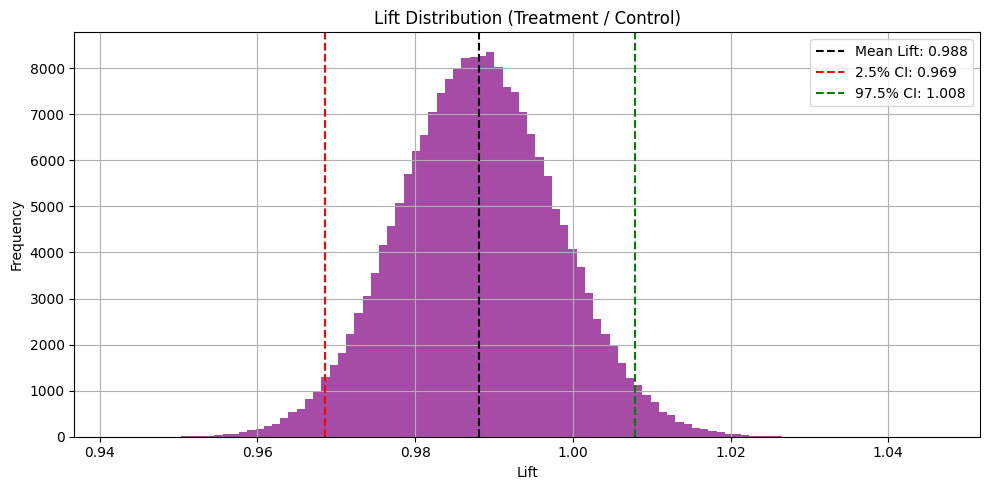

In [ ]:
ci_95 = lift_CrI   # 95% Credible Interval

plt.figure(figsize=(10, 5))
plt.hist(lift, bins=100, color='purple', alpha=0.7)
plt.axvline(lift_mean, color='black', linestyle='--', label=f'Mean Lift: {lift_mean:.3f}')
plt.axvline(ci_95[0], color='red', linestyle='--', label=f'2.5% CI: {ci_95[0]:.3f}')
plt.axvline(ci_95[1], color='green', linestyle='--', label=f'97.5% CI: {ci_95[1]:.3f}')
plt.title("Lift Distribution (Treatment / Control)")
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 베이지안 - proportion_effectsize

In [ ]:
# 데이터 불러오기
df = pd.read_csv("ab_data.csv")
pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [ ]:
# 종료 기준 체크
required_n = 5934

def ready_to_stop(n_A, n_B, required_n):
    return (n_A >= required_n) and (n_B >= required_n)

In [ ]:
# 집계

visit_A = (df['group'] == 'control').sum()
visit_B = (df['group'] == 'treatment').sum()
conv_A  = ((df['group']=='control') & (df['converted']==1)).sum()
conv_B  = ((df['group']=='treatment') & (df['converted']==1)).sum()

# --- 종료 기준 ---
assert ready_to_stop(visit_A, visit_B, required_n), "표본 수 미달: 아직 분석하지 마세요."

# --- 베이지안(Beta-Binomial) ---
a0, b0 = 1, 1
postA = (a0 + conv_A, b0 + visit_A - conv_A)
postB = (a0 + conv_B, b0 + visit_B - conv_B)

N = 200_000
rng = np.random.default_rng(42)
sA = beta.rvs(*postA, size=N, random_state=rng)
sB = beta.rvs(*postB, size=N, random_state=rng)
diff = sB - sA   # 절대 차이
lift = diff / sA  # 상대 리프트


# --- 목표 판정(절대 +2%p) ---
GO_ABS_DIFF = 0.02
THRESH = 0.95

prob_goal = (diff >= GO_ABS_DIFF).mean()
cri_diff  = np.quantile(diff, [0.025, 0.975])

goal_met = (prob_goal >= THRESH)

# --- (옵션) 빈도주의 병행 리포팅(양측) ---
z, pval = proportions_ztest([conv_A, conv_B], [visit_A, visit_B], alternative="two-sided")
ci_diff = confint_proportions_2indep(conv_B, visit_B, conv_A, visit_A, method="score")

# --- 출력 ---
print(f"A: {conv_A}/{visit_A} ({conv_A/visit_A:.3%}),  B: {conv_B}/{visit_B} ({conv_B/visit_B:.3%})")
print(f"P(pB - pA ≥ 2%p) = {prob_goal:.3f}  -> 목표달성?: {goal_met}")
print(f"diff 95% CrI = [{cri_diff[0]:.3%}, {cri_diff[1]:.3%}]")  # 가설(H0: 차이=0) 참고용
print(f"[freq] z={z:.3f}, p={pval:.3g}, diff 95% CI=({ci_diff[0]:.3%}, {ci_diff[1]:.3%})")

A: 17723/147202 (12.040%),  B: 17514/147276 (11.892%)
P(pB - pA ≥ 2%p) = 0.000  -> 목표달성?: False
diff 95% CrI = [-0.382%, 0.088%]
[freq] z=1.237, p=0.216, diff 95% CI=(-0.382%, 0.086%)


In [ ]:
# --- 집계 (데이터프레임 df에서 현재까지의 데이터 집계) ---
visit_A = (df['group'] == 'control').sum()
visit_B = (df['group'] == 'treatment').sum()
conv_A = ((df['group']=='control') & (df['converted']==1)).sum()
conv_B = ((df['group']=='treatment') & (df['converted']==1)).sum()

# --- 베이지안(Beta-Binomial) 분석 (현재까지 수집된 데이터로 사후 분포 계산) ---
# 사전 분포
a0, b0 = 1, 1

# 사후 분포의 모수
postA = (a0 + conv_A, b0 + visit_A - conv_A)
postB = (a0 + conv_B, b0 + visit_B - conv_B)

# 몬테카를로 시뮬레이션
N = 200_000
rng = np.random.default_rng(42)
sA = beta.rvs(*postA, size=N, random_state=rng)
sB = beta.rvs(*postB, size=N, random_state=rng)
diff = sB - sA # 절대 차이

# --- 목표 판정 기준 설정 ---
GO_ABS_DIFF = 0.02
THRESH = 0.95

# 목표 달성 확률 계산: P(pB - pA ≥ 0.02)
prob_goal = (diff >= GO_ABS_DIFF).mean()
goal_met = (prob_goal >= THRESH)

# --- 종료 기준 체크 함수 (베이지안 방식) ---
def ready_to_stop_bayesian(prob_goal, thresh=THRESH):
  # 또한, 극도로 작은 샘플 사이즈로 인해 불안정한 결과를 방지하기 위해 최소 샘플 조건을 추가할 수 있습니다.
  # 예를 들어, 최소 1000개의 방문이 있을 때만 분석을 시작하도록 합니다.
  MIN_VISIT = 1000
  if visit_A < MIN_VISIT or visit_B < MIN_VISIT:
    return False

  # 목표 달성 확률이 임계치를 넘으면 종료
  return prob_goal >= thresh


# --- 종료 기준 ---
if not ready_to_stop_bayesian(prob_goal):
  # 실험이 끝나지 않았으므로 분석을 중단하거나 다음 데이터를 수집
  print("⚠️ 표본 수(확신도) 미달: 아직 분석하지 마세요. 데이터를 더 수집하세요.")
  # return
  # 또는 예외를 발생시키거나 다음 데이터 수집 단계로 넘어갑니다.

# --- 출력 ---
cri_diff = np.quantile(diff, [0.025, 0.975]) # 95% 신념구간
print(f"A: {conv_A}/{visit_A} ({conv_A/visit_A:.3%}),  B: {conv_B}/{visit_B} ({conv_B/visit_B:.3%})")
print(f"P(pB - pA ≥ 2%p) = {prob_goal:.3f}  -> 목표달성?: {goal_met}")
print(f"diff 95% CrI = [{cri_diff[0]:.3%}, {cri_diff[1]:.3%}]")

⚠️ 표본 수(확신도) 미달: 아직 분석하지 마세요. 데이터를 더 수집하세요.
A: 17723/147202 (12.040%),  B: 17514/147276 (11.892%)
P(pB - pA ≥ 2%p) = 0.000  -> 목표달성?: False
diff 95% CrI = [-0.382%, 0.088%]


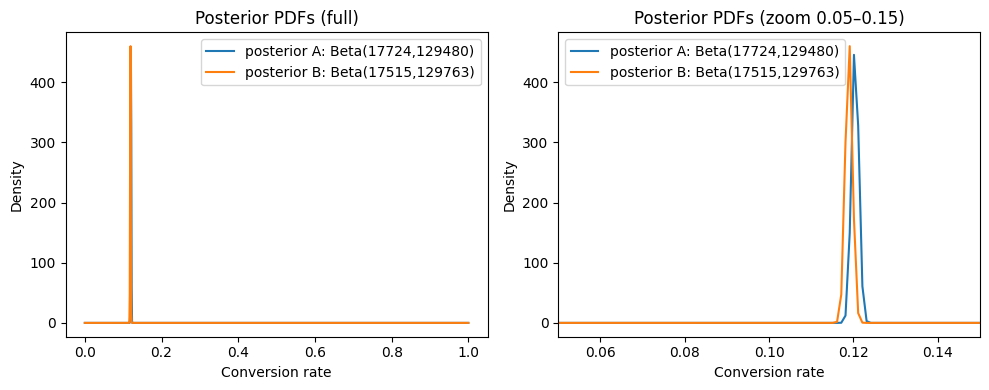

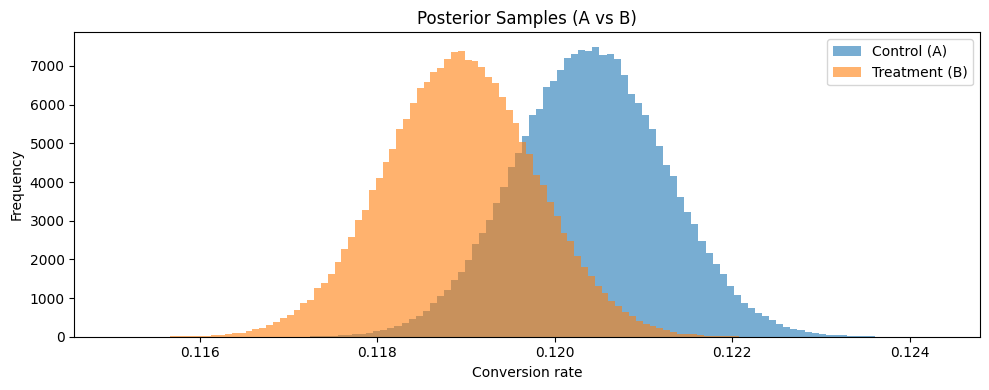

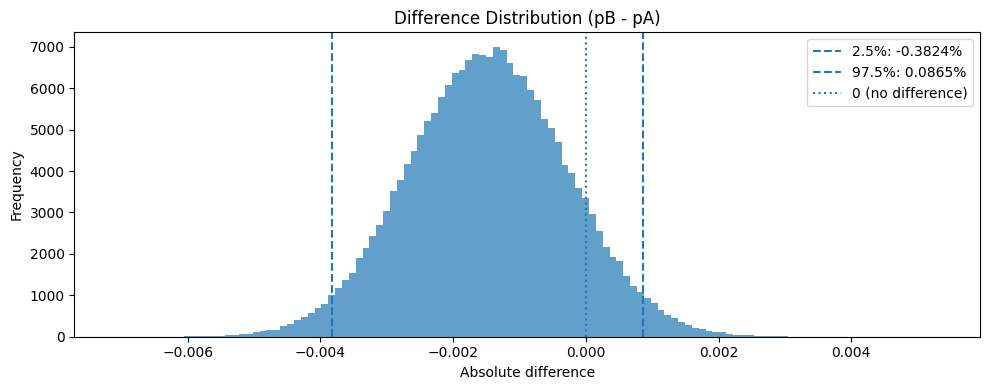

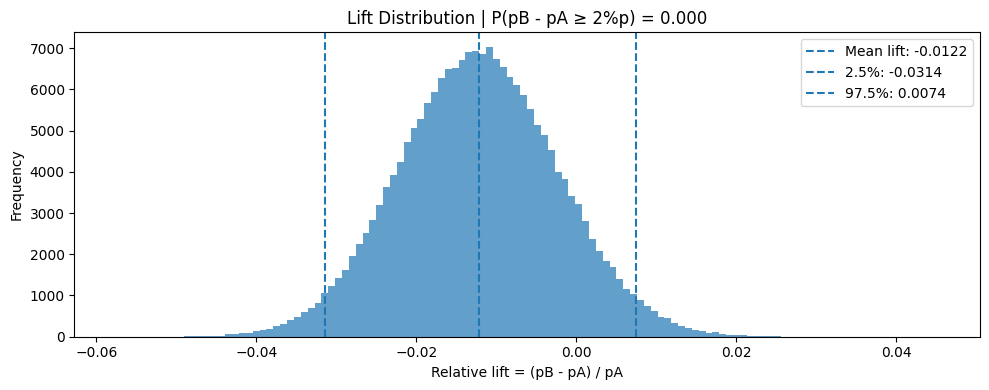

In [ ]:
# === 시각화 ===

# 0) 사후분포 객체 (PDF 그리기용)
posterior_A = beta(*postA)
posterior_B = beta(*postB)

# 1) Posterior PDFs: 전체 범위 + 확대(0.05~0.15)
x = np.linspace(0, 1, 1000)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(x, posterior_A.pdf(x), label=f"posterior A: Beta({postA[0]},{postA[1]})")
axes[0].plot(x, posterior_B.pdf(x), label=f"posterior B: Beta({postB[0]},{postB[1]})")
axes[0].set_xlabel("Conversion rate")
axes[0].set_ylabel("Density")
axes[0].set_title("Posterior PDFs (full)")
axes[0].legend()

axes[1].plot(x, posterior_A.pdf(x), label=f"posterior A: Beta({postA[0]},{postA[1]})")
axes[1].plot(x, posterior_B.pdf(x), label=f"posterior B: Beta({postB[0]},{postB[1]})")
axes[1].set_xlim(0.05, 0.15)
axes[1].set_xlabel("Conversion rate")
axes[1].set_ylabel("Density")
axes[1].set_title("Posterior PDFs (zoom 0.05–0.15)")
axes[1].legend()

plt.tight_layout()
plt.show()

# 2) Posterior samples histogram (A vs B)
plt.figure(figsize=(10, 4))
plt.hist(sA, bins=100, alpha=0.6, label="Control (A)")
plt.hist(sB, bins=100, alpha=0.6, label="Treatment (B)")
plt.title("Posterior Samples (A vs B)")
plt.xlabel("Conversion rate")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# 3) 차이 분포(diff = pB - pA) 히스토그램 + 95% CrI 표시
plt.figure(figsize=(10, 4))
plt.hist(diff, bins=120, alpha=0.7)
plt.axvline(ci_diff[0], linestyle="--", label=f"2.5%: {ci_diff[0]:.4%}")
plt.axvline(ci_diff[1], linestyle="--", label=f"97.5%: {ci_diff[1]:.4%}")
plt.axvline(0.0, linestyle=":", label="0 (no difference)")
plt.title("Difference Distribution (pB - pA)")
plt.xlabel("Absolute difference")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# 4) 리프트 분포(lift = (pB - pA) / pA) 히스토그램 + 평균/95% CrI + 목표확률
lift_mean = float(lift.mean())
ci_lift = np.percentile(lift, [2.5, 97.5])

plt.figure(figsize=(10, 4))
plt.hist(lift, bins=120, alpha=0.7)
plt.axvline(lift_mean, linestyle="--", label=f"Mean lift: {lift_mean:.4f}")
plt.axvline(ci_lift[0], linestyle="--", label=f"2.5%: {ci_lift[0]:.4f}")
plt.axvline(ci_lift[1], linestyle="--", label=f"97.5%: {ci_lift[1]:.4f}")
plt.title(f"Lift Distribution | P(pB - pA ≥ 2%p) = {prob_goal:.3f}")
plt.xlabel("Relative lift = (pB - pA) / pA")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 표본 전환율
pA_hat = conv_A / visit_A
pB_hat = conv_B / visit_B

# 풀드 비율 (귀무가설: pA = pB)
p_pool = (conv_A + conv_B) / (visit_A + visit_B)

# 표준오차 (difference in proportions)
se_diff = sqrt(p_pool * (1 - p_pool) * (1/visit_A + 1/visit_B))

# z 통계량
z_stat = (pB_hat - pA_hat) / se_diff

# p-value (양측검정)
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print(f"z-statistic = {z_stat:.4f}")
print(f"p-value (two-sided) = {p_value:.4f}")


z-statistic = -1.2369
p-value (two-sided) = 0.2161
